## ---------------------------------------------------------------------

## Import Modules

In [35]:
import tensorflow as tf
from datetime import datetime
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import concurrent.futures

In [36]:
from tensorflow.keras.utils import to_categorical, plot_model
from keras.preprocessing.image import load_img
from keras.models import Sequential, save_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, TimeDistributed, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [37]:
# Load the pre-trained model
model = load_model('/kaggle/input/fer-model/tensorflow1/fer/1/fer model.h5')

# Define the emotion dictionary
emotion_dict = {0: 'anger', 2: 'disgust', 3: 'fear', 4: 'happiness', 5: 'sadness', 6: 'surprise'}


# Load the Haar cascade for face detection
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Directory containing video files
DATA_DIR = '/kaggle/input/celeb-df-v2'

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(
/opt/conda/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


## Reduce Dataset

In [38]:
##### Splitting the dataset into train, validation, and test sets
from sklearn.model_selection import train_test_split

real_files = os.listdir(os.path.join(DATA_DIR, 'Celeb-real'))
fake_files = os.listdir(os.path.join(DATA_DIR, 'Celeb-synthesis'))

print(f"Real Files before dataset reduction: {len(real_files)}")
print(f"Fake Files before dataset reduction: {len(fake_files)}")

print("---------------------------------------------")

real_extra, real_files = train_test_split(real_files, test_size=0.5, random_state=42)
fake_extra, fake_files = train_test_split(fake_files, test_size=0.5, random_state=42)

print(f"Real Files after 50% reduction: {len(real_files)}")
print(f"Fake Files after 50% reduction: {len(fake_files)}")

Real Files before dataset reduction: 590
Fake Files before dataset reduction: 5639
---------------------------------------------
Real Files after 50% reduction: 295
Fake Files after 50% reduction: 2820


In [39]:
real_1 = real_files[:50]
real_2 = real_files[50:100]
real_3 = real_files[100:150]
real_4 = real_files[150:200]
real_5 = real_files[200:250]

fake_1 = fake_files[:50]
fake_2 = fake_files[50:100]
fake_3 = fake_files[100:150]
fake_4 = fake_files[150:200]
fake_5 = fake_files[200:250]

## Emotion Recognition

In [40]:
# Function to convert image and predict emotion
def convert_image(image):
    pic = cv2.resize(image, (48, 48))
    pic_rgb = cv2.cvtColor(pic, cv2.COLOR_GRAY2RGB)
    image_arr = np.array([pic_rgb], dtype='float32')
    image_arr /= 255
    prediction = model.predict(image_arr, verbose=None)[0]
    return np.argmax(prediction)

In [42]:
def process_frame(frame):
    prediction = convert_image(frame)
    return prediction

In [43]:
def extract_emotions(real_files, fake_files):
    
    df = pd.DataFrame(columns=['video', 'major_emotion', 'label'])
    
    for category in ("Celeb-synthesis", "Celeb-real"):
        folder_path = os.path.join(DATA_DIR, category)
        if(category == "Celeb-real"):
            files = real_files
            label = 'REAL'
        else:
            files = fake_files
            label = 'FAKE'
    
        # Process each video file
        for filename in tqdm(files):
            if filename.endswith(".mp4"):
                print(filename)
                path = os.path.join(folder_path, filename)  
                cap = cv2.VideoCapture(path)
                emotion_counts = {}
                frame_counter = 0

                while cap.isOpened():
                    ret, frame = cap.read()
                    if ret:
                        if frame_counter % 30 == 0:
                            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                            faces = face_cascade.detectMultiScale(gray, 1.1, 4)
                            with concurrent.futures.ThreadPoolExecutor() as executor:
                                for (x, y, w, h) in faces:
                                    roi_gray = gray[y:y + h, x:x + w]
                                    frame_processing_task = executor.submit(process_frame, roi_gray)
                                    emotion = emotion_dict.get(frame_processing_task.result())
                                    if emotion:
                                        emotion_counts[emotion] = emotion_counts.get(emotion, 0) + 1
                        frame_counter += 1
                    else:
                        break
                cap.release()

                # Determine the most frequent emotion
                if emotion_counts:
                    major_emotion = max(emotion_counts, key=emotion_counts.get)
                    df = df._append({'video': filename, 'major_emotion': major_emotion, 'label': label}, ignore_index=True)
                    print('Major Emotion:', major_emotion)
    return df

In [44]:
# emotions = extract_emotions(real_files, fake_files)

In [45]:
# # Save DataFrame to CSV
# emotions.to_csv('celeb-df emotions.csv', index=False)
# # Display DataFrame
# emotions.head()

In [46]:
emotion_df = pd.read_csv('/kaggle/working/celeb-df emotions.csv')

## Splitting Data

In [47]:
def split_files(real_files, fake_files):
    
    ## REAL 
    real_train, real_test = train_test_split(real_files, test_size=0.2, random_state=42)    # test size = 20%
    real_train, real_val = train_test_split(real_train, test_size=0.1, random_state=42)     # validation size = 10% of train (80%) = 8%

    ## FAKE
    fake_train, fake_test = train_test_split(fake_files, test_size=0.2, random_state=42)   
    fake_train, fake_val = train_test_split(fake_train, test_size=0.1, random_state=42)

    print("TESTING SET (20%)")
    print(f"Real Test Files: {len(real_test)}")
    print(f"Fake Test Files: {len(fake_test)}")

    print("---------------------------------------------")

    print("VALIDATION SET (8%)")
    print(f"Real Validation Files: {len(real_val)}")
    print(f"Fake Validation Files: {len(fake_val)}")

    print("---------------------------------------------")

    print("TRAINING SET (72%)")
    print(f"Real Train Files: {len(real_train)}")
    print(f"Fake Train Files: {len(fake_train)}")

    print("---------------------------------------------")


    train_files = [real_train, fake_train]
    val_files = [real_val, fake_val]
    test_files = [real_test, fake_test]

    # shuffle training data
    np.random.shuffle(train_files)

    print(f"Total Train Files: {len(real_train) + len(fake_train)}")
    print(f"Total Test Files: {len(real_test) + len(fake_test)}")
    print(f"Total Validation: {len(real_val) + len(fake_val)}")
    
    return train_files, test_files, val_files


In [48]:
## PARAMETERS

img_size = 64
seq_length = 50
batch_size = 32

## Feature Extraction

In [49]:
def detect_face(img):
#     gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(img, 1.3, 5)
    
    #if at least one face detected
    if(len(faces) > 0):
        for (x,y,w,h) in faces:
            cv2.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            face = img[y:y + h, x:x + w] #crop frame to face
            return face
    else:
        return img #if no face detected use frame as is
#         cv2.imshow("face",faces) 

In [50]:
def load_frames_from_video(video_path):
    cap = cv2.VideoCapture(video_path)
    frames = []
    frame_counter = 0
    while True:
        ret, frame = cap.read()
        if ret:
            if frame_counter % 30 == 0: 
                face = detect_face(frame)
                frame = cv2.resize(frame, (img_size, img_size))
                frame = frame.astype('float32') / 255.0
                frames.append(frame)
            frame_counter += 1
        if not ret:
            break
    cap.release()
    
#     print(len(frames))

    # Pad or slice frames to have a consistent sequence length
    if len(frames) < seq_length:
        frames += [np.zeros((img_size, img_size, 3))] * (seq_length - len(frames))
    frames = frames[:seq_length]

    return np.array(frames)

In [51]:
def setup_dataset(real_files, fake_files, is_training):
    frame_paths, labels = [], []
    for category in ("Celeb-real", "Celeb-synthesis"):
        folder_path = os.path.join(DATA_DIR, category)
        if(category == "Celeb-real"):
            files = real_files
        else:
            files = fake_files
        # videos = os.listdir(folder_path)
        for video_name in tqdm(files):
            video_path = os.path.join(folder_path, video_name)
            print(video_name, category)
            frames = load_frames_from_video(video_path)
            frame_paths.append(frames)
            labels.append(0 if category == "Celeb-real" else 1)

    dataset = tf.data.Dataset.from_tensor_slices((frame_paths, labels))
    if is_training:
        dataset = dataset.shuffle(buffer_size=100)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


## Model

In [52]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LSTM

#======================================================================================
#                               CNN COMPONENT
#======================================================================================

cnn_model = tf.keras.Sequential([
    Conv2D(8, (3, 3), activation='relu', input_shape=(img_size, img_size, 3)),  #8 filters, each 3x3, input images size 64x64x3(rgb channels), relu activation to output
    MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Dropout(0.4),
    Conv2D(16, (3, 3), activation='relu'),  #16 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),      #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Dropout(0.4),
    Conv2D(32, (3, 3), activation='relu'),  #32 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),       #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Dropout(0.4),
    Conv2D(64, (3, 3), activation='relu'), #64 filters, each 3x3, relu activation to output
    MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
#     Conv2D(128, (3, 3), activation='relu'), #64 filters, each 3x3, relu activation to output
#     MaxPooling2D((2, 2)),   #max pooling with pool size 2x2 (selects max value in every 2x2 filter -> reduces spatial dimension by factor of 2
    Flatten()       #flattens output into a 1D vector
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [53]:
from tensorflow.keras.layers import Dense, TimeDistributed, Dropout

#======================================================================================
#                               FULL FER MODEL
#======================================================================================

model = tf.keras.Sequential([
    TimeDistributed(cnn_model, input_shape=(seq_length, img_size, img_size, 3)),        #CNN MODEL
    LSTM(32),      #LSTM

    #===================================================
    #              FULLY CONNECTED LAYER
    #===================================================

    #utilizes the extracted features and temporal information to learn complex relationships and transform the features into higher-level representations.

    Dense(64, activation='relu'),       #fixed-length representation input from LSTM and applies ReLU activation function -> introduces non-linearity -> learn complex relationships between features.
    Dropout(0.4),       #prevent overfitting -> 20% of output set to 0
    
    Dense(32, activation='relu'),       #fixed-length representation input from LSTM and applies ReLU activation function -> introduces non-linearity -> learn complex relationships between features.
    Dropout(0.2),       #prevent overfitting -> 20% of output set to 0

    #===================================================
    #               OUTPUT LAYER
    #===================================================

    #binary classification using sigmoid activation -> 0 or 1 -> probability of belonging to class
    #if value > 0.5 -> fake, if < 0.5 -> real

    Dense(1, activation='sigmoid')
])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [54]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),     #adam optimizer with learning rate 0.0001
              loss='binary_crossentropy',       #loss function
              metrics=['accuracy'])

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_1              │ ?                      │        24,528 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,528 (95.81 KB)

 Trainable params: 24,528 (95.81 KB)

 Non-trainable params: 0 (0.00 B)

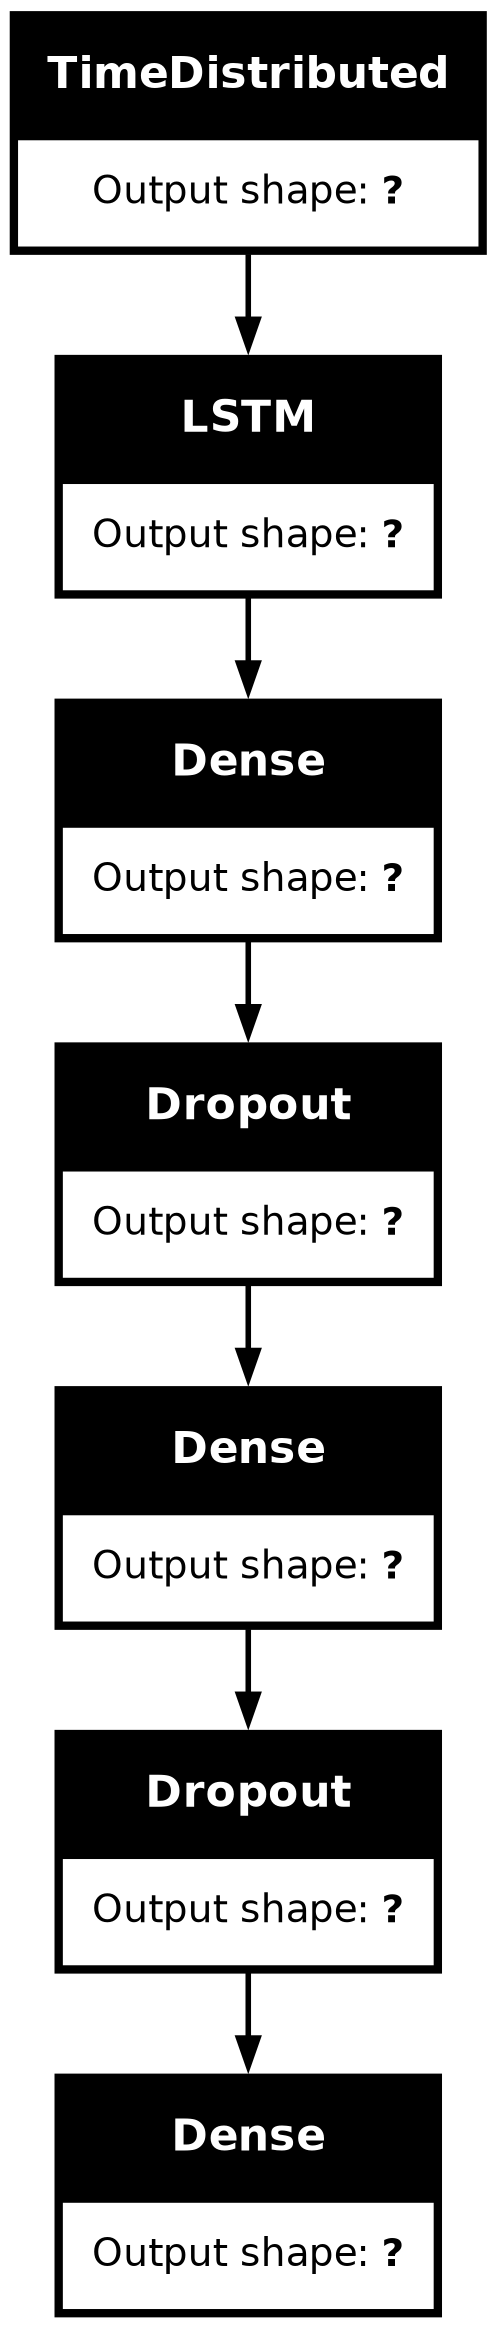

In [55]:
from tensorflow.keras.utils import to_categorical, plot_model

model.summary()

# Plot the model architectures
plot_model(model, show_shapes=True, to_file="model.png")

## Data Visualization

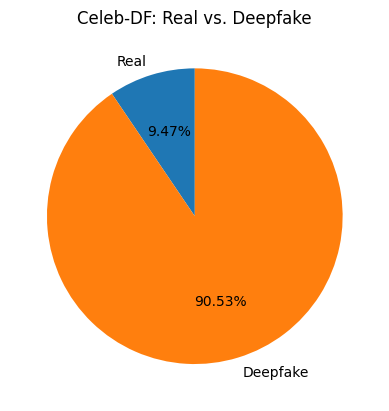

In [56]:
labeled = emotion_df['label'].value_counts()

# print(len(emotions))

plt.pie([[emotion_df["label"] == 'REAL'].value_counts(), [emotion_df["label"] == 'FAKE'].value_counts()], labels=['Real', 'Deepfake'], autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF: Real vs. Deepfake")
plt.savefig('Celeb-DF real vs fake.png',bbox_inches='tight')
plt.show()

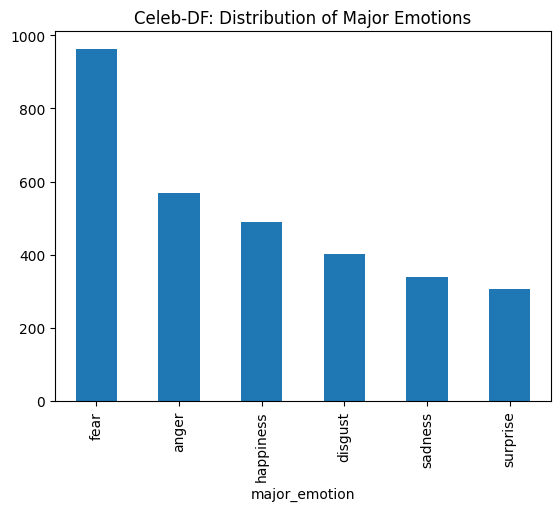

In [57]:
# Plot emotions
emo_data = emotion_df['major_emotion'].value_counts().plot(kind='bar')
# plt.pie(emo_data, labels=emo_data.index, autopct='%1.2f%%', startangle=90)
plt.title("Celeb-DF: Distribution of Major Emotions")
plt.savefig('Celeb-DF emotion distribution bar.png',bbox_inches='tight')
plt.show()


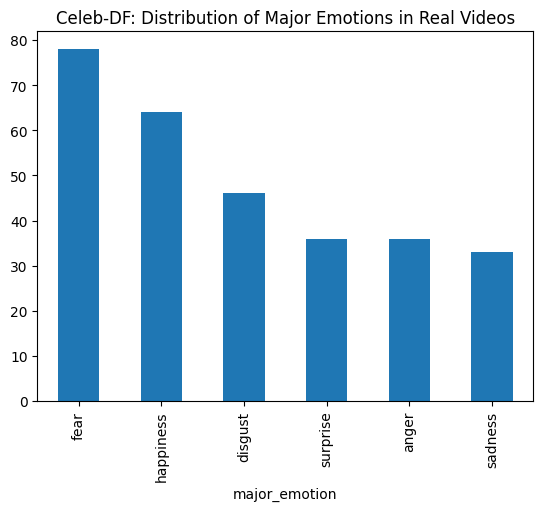

In [58]:
real_emotions = emotion_df[emotion_df["label"] == 'REAL']["major_emotion"].value_counts().plot(kind='bar')
# plt.pie(real_emotions, labels=real_emotions.index, autopct='%1.2f%%', startangle=90)
plt.title("Celeb-DF: Distribution of Major Emotions in Real Videos")
plt.savefig('Celeb-DF emotion distribution real bar.png',bbox_inches='tight')
plt.show()


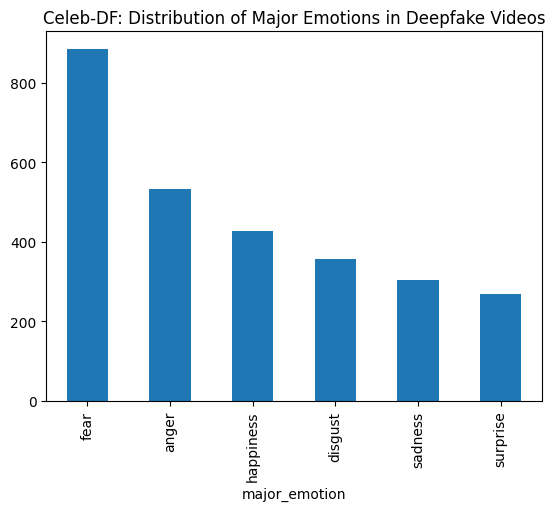

In [59]:
fake_emotions = emotion_df[emotion_df["label"] == 'FAKE']["major_emotion"].value_counts().plot(kind='bar')
# plt.pie(fake_emotions, labels=fake_emotions.index, autopct='%1.2f%%', startangle=90)
plt.title("Celeb-DF: Distribution of Major Emotions in Deepfake Videos")
plt.savefig('Celeb-DF emotion distribution fake bar.png',bbox_inches='tight')
plt.show()


In [62]:
from tqdm.notebook import tqdm

## Happiness

64 426


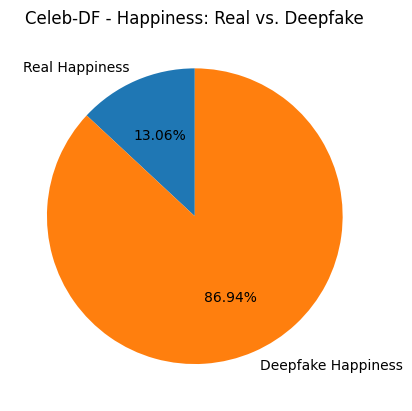

In [61]:
real_happiness = emotion_df[(emotion_df["major_emotion"] == 'happiness') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_happiness = emotion_df[(emotion_df["major_emotion"] == 'happiness') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_happiness), len(fake_happiness)]
labels = ["Real Happiness", "Deepfake Happiness"]

print(len(real_happiness), len(fake_happiness))

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF - Happiness: Real vs. Deepfake")
plt.savefig('Celeb-DF happiness real vs fake.png',bbox_inches='tight')
plt.show()

In [63]:
happy_train, happy_test, happy_val = split_files(real_happiness, fake_happiness)

TESTING SET (20%)
Real Test Files: 13
Fake Test Files: 86
---------------------------------------------
VALIDATION SET (8%)
Real Validation Files: 6
Fake Validation Files: 34
---------------------------------------------
TRAINING SET (72%)
Real Train Files: 45
Fake Train Files: 306
---------------------------------------------
Total Train Files: 351
Total Test Files: 99
Total Validation: 40


In [66]:
happy_train_data = setup_dataset(happy_train[0], happy_train[1],  True)
# happy_val_data = setup_dataset(happy_val[0], happy_val[1], False)
# happy_test_data = setup_dataset(happy_test[0], happy_test[1], False)

  0%|          | 0/45 [00:00<?, ?it/s]

id46_0009.mp4 Celeb-real
id11_0002.mp4 Celeb-real
id7_0000.mp4 Celeb-real
id41_0004.mp4 Celeb-real
id22_0003.mp4 Celeb-real
id26_0001.mp4 Celeb-real
id12_0003.mp4 Celeb-real
id5_0000.mp4 Celeb-real
id45_0007.mp4 Celeb-real
id41_0005.mp4 Celeb-real
id8_0003.mp4 Celeb-real
id22_0000.mp4 Celeb-real
id13_0007.mp4 Celeb-real
id28_0009.mp4 Celeb-real
id2_0005.mp4 Celeb-real
id12_0006.mp4 Celeb-real
id33_0009.mp4 Celeb-real
id25_0001.mp4 Celeb-real
id4_0005.mp4 Celeb-real
id16_0002.mp4 Celeb-real
id60_0001.mp4 Celeb-real
id7_0003.mp4 Celeb-real
id53_0008.mp4 Celeb-real
id33_0003.mp4 Celeb-real
id26_0009.mp4 Celeb-real
id20_0008.mp4 Celeb-real
id29_0003.mp4 Celeb-real
id13_0006.mp4 Celeb-real
id38_0004.mp4 Celeb-real
id34_0001.mp4 Celeb-real
id0_0006.mp4 Celeb-real
id44_0001.mp4 Celeb-real
id51_0000.mp4 Celeb-real
id59_0001.mp4 Celeb-real
id34_0008.mp4 Celeb-real
id23_0007.mp4 Celeb-real
id9_0007.mp4 Celeb-real
id55_0009.mp4 Celeb-real
id34_0000.mp4 Celeb-real
id5_0001.mp4 Celeb-real
id33_0005

  0%|          | 0/306 [00:00<?, ?it/s]

id28_id9_0009.mp4 Celeb-synthesis
id61_id60_0009.mp4 Celeb-synthesis
id23_id29_0007.mp4 Celeb-synthesis
id53_id57_0000.mp4 Celeb-synthesis
id60_id5_0009.mp4 Celeb-synthesis
id29_id23_0003.mp4 Celeb-synthesis
id9_id35_0007.mp4 Celeb-synthesis
id53_id56_0004.mp4 Celeb-synthesis
id53_id58_0005.mp4 Celeb-synthesis
id26_id0_0009.mp4 Celeb-synthesis
id34_id29_0006.mp4 Celeb-synthesis
id23_id35_0007.mp4 Celeb-synthesis
id28_id22_0002.mp4 Celeb-synthesis
id3_id17_0000.mp4 Celeb-synthesis
id40_id41_0004.mp4 Celeb-synthesis
id28_id21_0007.mp4 Celeb-synthesis
id8_id5_0003.mp4 Celeb-synthesis
id29_id33_0000.mp4 Celeb-synthesis
id16_id6_0007.mp4 Celeb-synthesis
id23_id25_0000.mp4 Celeb-synthesis
id34_id31_0000.mp4 Celeb-synthesis
id35_id29_0008.mp4 Celeb-synthesis
id10_id7_0007.mp4 Celeb-synthesis
id40_id47_0004.mp4 Celeb-synthesis
id17_id0_0006.mp4 Celeb-synthesis
id9_id3_0006.mp4 Celeb-synthesis
id9_id3_0007.mp4 Celeb-synthesis
id24_id19_0000.mp4 Celeb-synthesis
id50_id56_0008.mp4 Celeb-synthesis

In [ ]:
# happy_train_len = len(happy_train[0]) + len(happy_train[1])
# happy_test_len = len(happy_test[0]) + len(happy_test[1])
# happy_val_len = len(happy_val[0]) + len(happy_val[1])

sum(map(len, happy_train))

In [ ]:

# Calculate the number of steps per epoch for training and validation
train_steps_per_epoch = np.ceil(sum(map(len, happy_train)) / batch_size).astype(int)
val_steps_per_epoch = np.ceil(sum(map(len, happy_val)) / batch_size).astype(int)
test_steps_per_epoch = np.ceil(sum(map(len, happy_test)) / batch_size).astype(int)

# Calculate the number of samples in each set
num_train_samples = sum(map(len, happy_train))
num_val_samples = sum(map(len, happy_val))
num_test_samples = sum(map(len, happy_test))

# Print the number of samples in each set
print("Number of training samples:", num_train_samples)
print("Number of validation samples:", num_val_samples)
print("Number of test samples:", num_test_samples)

print("train_steps_per_epoch:", train_steps_per_epoch)
print("val_steps_per_epoch", val_steps_per_epoch)
print("test_steps_per_epoch", test_steps_per_epoch)

In [ ]:
# Callback for testing

class TestCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_loss, test_acc = model.evaluate(happy_test_data, steps=test_steps_per_epoch)
        print('Test loss:', test_loss)
        print('Test accuracy:', test_acc)

In [ ]:
class AccuracyPlotCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(AccuracyPlotCallback, self).__init__()
        self.train_acc = []
        self.val_acc = []

    def on_epoch_end(self, epoch, logs=None):
        self.train_acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        plt.figure(figsize=(5, 3))
        plt.plot(self.train_acc, label='Training Accuracy')
        plt.plot(self.val_acc, label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.grid(True)
        plt.show()

In [ ]:
from sklearn.metrics import classification_report

class MetricsPlotCallback(tf.keras.callbacks.Callback):
    def on_train_end(self, logs=None):
        test_iterator = iter(happy_test_data)
        y_true = []
        y_pred = []
        for _ in range(test_steps_per_epoch):
            X_test, y_test = next(test_iterator)
            y_true.extend(y_test)
            y_pred.extend((model.predict(X_test) > 0.5).astype(int).flatten())
        cm = confusion_matrix(y_true, y_pred)
        labels = ['Real', 'Deepfake']
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        ax1 = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True, xticklabels=labels, yticklabels=labels)
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('True')
        ax1.set_title('Confusion Matrix')
#         ax1.savefig('DFDC_happy_confusion.png')
        
        report = classification_report(y_true, y_pred, target_names=labels)
        ax2.text(0, 0.5, report, fontsize=12, verticalalignment='center')
        ax2.axis('off')
        ax2.set_title('Classification Report')

In [ ]:
# checkpoint = ModelCheckpoint(filepath='./Plots/dfdc_model_plots_{epoch}.keras', monitor='val_loss', verbose=1, save_best_only=False, mode='auto', save_freq='epoch')
        
metrics_plot_callback = MetricsPlotCallback()

test_callback = TestCallback()

accuracy_plot_callback = AccuracyPlotCallback()

In [ ]:
happy_history = model.fit(happy_train_data,
                         steps_per_epoch=train_steps_per_epoch,
                         epochs=10,
                         batch_size=batch_size,
                         validation_data=happy_val_data,
                         validation_steps=val_steps_per_epoch,
                         callbacks=[test_callback, accuracy_plot_callback, metrics_plot_callback]
                         )

## Sadness

In [ ]:
real_sadness = emotion_df[(emotion_df["major_emotion"] == 'sadness') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_sadness = emotion_df[(emotion_df["major_emotion"] == 'sadness') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_sadness), len(fake_sadness)]
labels = ["Real Sadness", "Deepfake Sadness"]

print(len(real_sadness) + len(fake_sadness))
print(sizes)


plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF - Sadness: Real vs. Deepfake")
plt.savefig('Celeb-DF sadness real vs fake.png',bbox_inches='tight')
plt.show()

## Anger

In [ ]:
real_anger = emotion_df[(emotion_df["major_emotion"] == 'anger') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_anger = emotion_df[(emotion_df["major_emotion"] == 'anger') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_anger), len(fake_anger)]
labels = ["Real Anger", "Deepfake Anger"]

print(len(real_anger) + len(fake_anger))
print(sizes)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF - Anger: Real vs. Deepfake")
plt.savefig('Celeb-DF anger real vs fake.png',bbox_inches='tight')
plt.show()

## Fear

In [ ]:
real_fear = emotion_df[(emotion_df["major_emotion"] == 'fear') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_fear = emotion_df[(emotion_df["major_emotion"] == 'fear') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_fear), len(fake_fear)]
labels = ["Real Fear", "Deepfake Fear"]

print(len(real_fear) + len(fake_fear))
print(sizes)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF - Fear: Real vs. Deepfake")
plt.savefig('Celeb-DF fear real vs fake.png',bbox_inches='tight')
plt.show()

## Disgust

In [ ]:
real_disgust = emotion_df[(emotion_df["major_emotion"] == 'disgust') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_disgust = emotion_df[(emotion_df["major_emotion"] == 'disgust') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_disgust), len(fake_disgust)]
labels = ["Real Disgust", "Deepfake Disgust"]

print(len(real_disgust) + len(fake_disgust))
print(sizes)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF - Disgust: Real vs. Deepfake")
plt.savefig('Celeb-DF disgust real vs fake.png',bbox_inches='tight')
plt.show()

## Surprise

In [ ]:
real_surprise = emotion_df[(emotion_df["major_emotion"] == 'surprise') & (emotion_df["label"] == 'REAL')]["video"].to_list()
fake_surprise = emotion_df[(emotion_df["major_emotion"] == 'surprise') & (emotion_df["label"] == 'FAKE')]["video"].to_list()

sizes = [len(real_surprise), len(fake_surprise)]
labels = ["Real Surprise", "Deepfake Surprise"]

print(len(real_surprise) + len(fake_surprise))
print(sizes)

plt.pie(sizes, labels=labels, autopct='%1.2f%%', startangle=90)

plt.title("Celeb-DF - Surprise: Real vs. Deepfake")
plt.savefig('Celeb-DF surprise real vs fake.png',bbox_inches='tight')
plt.show()